In [2]:
# Tyler Palmer
# Student ID: 801058786
# Github: https://github.com/TPal49
# Homework 2

import time
import torch
from torch import nn
from matplotlib import pyplot as plt



In [3]:
!pip install d2l==1.0.0-beta0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=a859e76ba3ad6921b964df04fa6258b9b5e198373187d3cdf9d025c414be9d7d
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninsta

In [4]:
from d2l import torch as d2l
import torchvision
from torchvision import transforms
d2l.use_svg_display()


class FashionMNIST(d2l.DataModule): 
  def __init__(self, batch_size=64, resize=(28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
    self.val = torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)

data = FashionMNIST()

@d2l.add_to_class(d2l.Module)
def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l


@d2l.add_to_class(FashionMNIST)  
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

@d2l.add_to_class(FashionMNIST)  
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,num_workers=self.num_workers)

@d2l.add_to_class(FashionMNIST)  
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Problem 1 (20pts)

Let’s modernize LeNet as we did in the lectures. Implement and test the following changes over FashionMNIST

Replace the average pooling with max-pooling.
Replace the softmax layer with ReLU.
Start training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against the baseline we did in the lectures.

In [4]:
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier): 
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

'251.64 sec has elapsed'

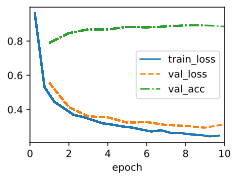

In [ ]:
start = time.time()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
f'{time.time() - start:.2f} sec has elapsed'

Problem 2 (40pts)

Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.

Adjust the convolution window size.

Adjust the number of output channels (width of each layer).

Adjust the number of convolution layers.

Adjust the number of fully connected layers.

Explore the learning rates.

For all training adjustments, restart training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against each other and the baseline in problem 1. Argue which adjustment presents the better benefit and generalization. Measure and compare theoretical computation complexity (number of operations and parameters size) using ptflops https://pypi.org/project/ptflops/

In [ ]:
class LeNet(d2l.Classifier): 
    """LeNET but I try to make if different a couple times"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # Code is commented / Uncommented to utilize the different Model Classes "Model 1" represents the previously used base LeNET model.
            #nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(), # Model 1
            #nn.LazyConv2d(6, kernel_size=3, padding=1), nn.ReLU(),# Model 2
            nn.LazyConv2d(16, kernel_size=3, padding=1), nn.ReLU(),# Model 3
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),# Model 1
            nn.MaxPool2d(kernel_size=3, stride=1),# Model 2 & 3
            nn.LazyConv2d(8, kernel_size = 1, padding = 0), nn.ReLU(),# Model 2 & 3
            nn.Flatten(),
            #nn.LazyLinear(120), nn.ReLU(), # Model 1
            nn.LazyLinear(64), nn.ReLU(),# Model 2 & 3
            #nn.LazyLinear(84), nn.ReLU(),# Model 1
            nn.LazyLinear(32), nn.ReLU(),# Model 2 & 3
            nn.LazyLinear(16), nn.ReLU(),# Model 3
            nn.LazyLinear(num_classes))

'336.85 sec has elapsed'

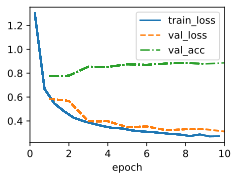

In [ ]:
start = time.time()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
f'{time.time() - start:.2f} sec has elapsed'

Problem 3 (10pts)

Pick the best model from problem 2. Apply dropout to LeNet-5 across all experiments in problem 2. Does it improve the training? For all training adjustments, restart training from scratch based on FashinMNIST. Compare the training loss, training accuracy, and validation accuracy against the best model in problem 2.

In [17]:
class LeNet(d2l.Classifier): 
    """LeNET but I try to make if different a couple times and now dropout"""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # Code is commented / Uncommented to utilize the different Model Classes "Model 1" represents the previously used base LeNET model.
            #nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(), # Model 1
            nn.LazyConv2d(6, kernel_size=3, padding=1), nn.ReLU(),# Model 2
            #nn.LazyConv2d(16, kernel_size=3, padding=1), nn.ReLU(),# Model 3
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),# Model 1
            nn.MaxPool2d(kernel_size=3, stride=1),# Model 2 & 3
            nn.LazyConv2d(8, kernel_size = 1, padding = 0), nn.ReLU(),# Model 2 & 3
            nn.Flatten(),
            #nn.LazyLinear(120), nn.ReLU(),nn.Dropout(0.25), # Model 1
            nn.LazyLinear(64), nn.ReLU(),nn.Dropout(0.25),# Model 2 & 3
            #nn.LazyLinear(84), nn.ReLU(), nn.Dropout(0.25),# Model 1
            nn.LazyLinear(32), nn.ReLU(), nn.Dropout(0.25),# Model 2 & 3
            #nn.LazyLinear(16), nn.ReLU(), nn.Dropout(0.25),# Model 3
            nn.LazyLinear(num_classes))

'178.15 sec has elapsed'

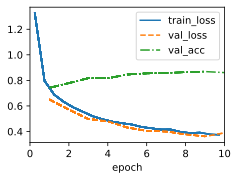

In [19]:
start = time.time()
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)
f'{time.time() - start:.2f} sec has elapsed'

Problem 4 (30 pts)

AlexNet may be too complex for the Fashion-MNIST dataset, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Compare your training loss, training, and validation accuracy against the best model in Problem 3 and Problem 2. Also, measure your computational saving in the number of operations as well as the number of parameters in your network using ptflops https://pypi.org/project/ptflops/

In [5]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(48, kernel_size=5, stride=3, padding=2), # out channels reduced to 48, kernel to a 5x5, padding to a 2, stride 3
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1), # max pool kernel reduced to 2x2, stride reduced to 1
            nn.LazyConv2d(128, kernel_size=5, padding=2), nn.ReLU(), # out channels reduced to 128
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(), # out channels reduced to 256
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(), # out channels reduced to 256
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(126), nn.ReLU(),nn.Dropout(p=0.4), # out channels reduced to 126
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

'1331.99 sec has elapsed'

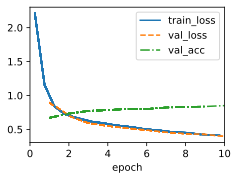

In [13]:
start = time.time()
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=32, resize=(32, 32))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
f'{time.time() - start:.2f} sec has elapsed'